In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
from tqdm import tqdm
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [35]:
dataset=pd.read_csv('/kaggle/input/digit-recognizer/train.csv')


dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
ds=dataset.to_numpy()

y_train=ds[:,0]



x_train=ds[:,1:]



In [73]:
x_train=x_train.reshape(-1,28,28,1)
# y_train=y_train.reshape(-1,1)
x_train=x_train/255.0
x_train.shape

(42000, 28, 28, 1)

In [74]:
# x_train=torch.from_numpy(x_train)
y_train=torch.from_numpy(y_train.reshape(len(y_train),1))
y_train.shape


torch.Size([42000, 1])

In [75]:
x_train.dtype

dtype('float64')

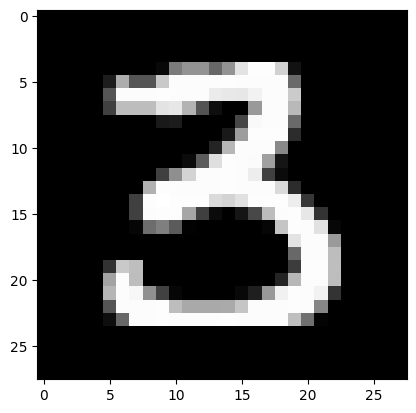

In [69]:
import matplotlib.pyplot as plt
x_train.shape
plt.imshow(x_train[0], cmap='gray')

In [76]:
y_train.shape

torch.Size([42000, 1])

In [80]:
# this is a dataset class.
# storing the dataset with labels. 
class Dataset():
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        if self.transform:
            image = self.transform(image)
        
        return (image, label)

In [81]:
transformers_test=transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5,], [0.5,])])




train_dataset = Dataset(images=x_train, labels=y_train, transform=transformers_test)
#test_dataset  = Dataset(images=x_test, labels=y_test, transform=transformers_test)

In [82]:
train_loader=DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
#test_loader=DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

In [83]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,32,kernel_size=3,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2=nn.Conv2d(32,64, kernel_size=3, padding=1)
        self.fc1=nn.Linear(64*7*7, 128)
        self.fc2=nn.Linear(128,10)
        
    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,64*7*7)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [89]:
model=CNN()
loss_function=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

In [90]:
def predict_test_data(model, test_loader):
    
    num_correct = 0
    num_samples = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.float()
            y_test = y_test.float()

            # Calculate loss (forward propagation)
            test_preds = model(X_test)
            test_loss  = loss_function(test_preds, y_test)
            
            # Calculate accuracy
            rounded_test_preds = torch.round(test_preds)
            num_correct += torch.sum(rounded_test_preds == y_test)
            num_samples += len(y_test)
        
    model.train()
    
    test_acc = num_correct/num_samples
    
    return test_loss, test_acc

In [92]:
train_losses=[]
test_losses=[]
train_accs=[]
test_accs=[]

for epoch in range(10):
    num_correct=0
    num_samples=0
    
    for batch, (x_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x_train=x_train.float()
        y_train=y_train.float()
        
        train_preds=model(x_train)
        train_loss=loss_function(train_preds, y_train)
        
        with torch.no_grad():
            rounded_train_preds=torch.round(train_preds)
            num_correct+=torch.sum(rounded_train_preds==y_train)
            num_samples+=len(y_train)
            
        optimizer.zero_grad()
        train_loss.backward()
        
        optimizer.step()
        
    train_acc=num_correct/num_samples
    test_loss, test_acc=predict_test_data(model, train_loader)
    
    
    test_losses.append(test_loss.item())
    
    test_accs.append(test_acc.item())
    
    print(f'Epoch: {epoch} \t|' 
           
            f' Test loss: {np.round(test_loss.item(),5)} \t|' \
            
            f' Test acc: {np.round(test_acc.item(),5)}')

100%|██████████| 1312/1312 [00:37<00:00, 34.64it/s]


Epoch: 0 	| Test loss: 9.55347 	| Test acc: 0.90392


100%|██████████| 1312/1312 [00:37<00:00, 34.57it/s]


Epoch: 1 	| Test loss: 11.29745 	| Test acc: 0.96966


100%|██████████| 1312/1312 [00:38<00:00, 34.27it/s]


Epoch: 2 	| Test loss: 9.23527 	| Test acc: 0.96942


100%|██████████| 1312/1312 [00:37<00:00, 34.69it/s]


Epoch: 3 	| Test loss: 6.96493 	| Test acc: 0.96894


100%|██████████| 1312/1312 [00:38<00:00, 34.50it/s]


Epoch: 4 	| Test loss: 7.04473 	| Test acc: 0.96918


100%|██████████| 1312/1312 [00:38<00:00, 34.14it/s]


Epoch: 5 	| Test loss: 9.3188 	| Test acc: 0.96966


100%|██████████| 1312/1312 [00:37<00:00, 34.69it/s]


Epoch: 6 	| Test loss: 8.88556 	| Test acc: 0.9687


100%|██████████| 1312/1312 [00:37<00:00, 34.61it/s]


Epoch: 7 	| Test loss: 8.68517 	| Test acc: 0.96942


100%|██████████| 1312/1312 [00:38<00:00, 34.38it/s]


Epoch: 8 	| Test loss: 8.49013 	| Test acc: 0.96989


100%|██████████| 1312/1312 [00:37<00:00, 34.55it/s]


Epoch: 9 	| Test loss: 6.25909 	| Test acc: 0.96966


Final Accuracy is around 97%